In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filePath = "data/ml-100k/u1.base"
with open(filePath, "rt") as dataPath:
    raw_data = dataPath.read().splitlines()
datapoints = [[int(i) for i in data.split("\t")] for data in raw_data]

# indexing on users/movies starts at 1, reset to index from 0, this will be important when we do testing
datapoints = np.array([[row[0], row[1], row[2], row[3]] for row in datapoints])
np.random.shuffle(datapoints)

user_ids = set([datapoint[0] for datapoint in datapoints])
n_users = len(user_ids)
max_user = max(user_ids) + 1
print("n users:", n_users)
items_ids = set([datapoint[1] for datapoint in datapoints])
n_items = len(items_ids)
max_item = max(items_ids) + 1
print("n items:", n_items)

n users: 943
n items: 1650


In [3]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

In [4]:
n_particles = 4
k = 3
var = 0.5
particles = [(1 / n_particles, {"u": np.random.normal(size=(max_user, k)),
                                "v": np.random.normal(size=(max_item, k)),
                                "var_u": 1.0,
                                "var_i": 1.0}) for _ in range(n_particles)]

user_history = {} # user_rating_history[user_id]["item_ids"], user_rating_history[user_id]["ratings"]
item_history = {} # item_rating_history[item_id]["user_ids"], item_rating_history[item_id]["ratings"]
sses = []

# what we're going to do here is assume that OUR system made the item recommendation and is observing the
# rating we have in the dataset ... it's sort of like we're starting at line 11
for _idx, (user_id, item_id, rating, ts) in enumerate(datapoints):
    pred_rating = [np.dot(particle[1]["u"][user_id, :], particle[1]["v"][item_id, :]) for particle in particles]
    errors = pred_rating - rating
    sse = np.sum(errors ** 2)
    if _idx % 101 == 0:
        sses.append(sse)
    if _idx % 1001 == 0:
        print("sum of squared errors:", sse)
    
    # line 17
    precision_u_i = []
    eta_u_i = []
    for particle in particles:
        if user_id not in user_history:
            precision_u_i.append(np.eye(k))
            eta_u_i.append(np.zeros(k))
        else:
            v_j = particle[1]["v"][user_history[user_id]["item_ids"], :]
            lambda_u_i = 1 / var * \
                np.dot(v_j.T, v_j) + \
                1 / particle[1]["var_u"] * np.eye(k)
            
            precision_u_i.append(lambda_u_i)
            
            eta = np.sum(
                np.multiply(
                    v_j,
                    np.array(user_history[user_id]["ratings"]).reshape(-1, 1)
                ),
                axis=0
            )
            eta_u_i.append(eta.reshape(-1))
            
    # line 18
    weights = []
    mus = [1 / var * np.dot(np.linalg.inv(lambda_), eta) for lambda_, eta in zip(precision_u_i, eta_u_i)]
    for particle, mu, precision in zip(particles, mus, precision_u_i):
        v_j = particle[1]["v"][item_id, :]
        cov = 1 / var + np.dot(np.dot(v_j.T, precision), v_j)
        w = np.random.normal(
            np.dot(v_j.T, mu),
            cov
        )
        weights.append(w)
    normalized_weights = softmax(weights)
    
    # line 19
    ds = [np.random.choice(range(n_particles), p=normalized_weights) for _ in range(n_particles)]
    p_prime = []
    for d in ds:
        p_prime.append((1 / n_particles, particles[d][1]))
        
    for particle, precision, e in zip(p_prime, precision_u_i, eta_u_i):
        # line 21
        v_j = particle[1]["v"][item_id, :]
        add_to_precision = 1 / var * np.dot(v_j.reshape(-1, 1), v_j.reshape(1, -1))
        precision += add_to_precision
        add_to_eta = rating * v_j
        e += add_to_eta
        # line 22
        particle[1]["u"][user_id, :] = np.random.multivariate_normal(
            1 / var * np.dot(np.linalg.inv(precision), e),
            np.linalg.inv(precision)
        )
        # line 24
        if item_id not in item_history:
            precision_v_i = np.eye(k)
            eta = np.zeros(k)
        else:
            u_i = particle[1]["u"][item_history[item_id]["user_ids"], :]
            precision_v_i = 1 / var * \
                np.dot(u_i.T, u_i) + \
                1 / particle[1]["var_i"] * np.eye(k)
            
            eta = np.sum(
                np.multiply(
                    u_i,
                    np.array(item_history[item_id]["ratings"]).reshape(-1, 1)
                ),
                axis=0
            )
        # line 25
        particle[1]["v"][item_id, :] = np.random.multivariate_normal(
            1 / var * np.dot(np.linalg.inv(precision_v_i), eta),
            np.linalg.inv(precision_v_i)
        )
        
    # line 28
    particles = p_prime
    
    if user_id not in user_history:
        user_history[user_id] = {"item_ids": [], "ratings": []}
    if item_id not in item_history:
        item_history[item_id] = {"user_ids": [], "ratings": []}
    user_history[user_id]["item_ids"].append(item_id)
    user_history[user_id]["ratings"].append(rating)
    item_history[item_id]["user_ids"].append(user_id)
    item_history[item_id]["ratings"].append(rating)

sum of squared errors: 47.53726840663723
sum of squared errors: 17.866147762679624


/home/michael/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/home/michael/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/michael/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in less


sum of squared errors: 0.23683174068244617
sum of squared errors: 22.615209309036246
sum of squared errors: 335.9125847130906
sum of squared errors: 94.09767082760105
sum of squared errors: 2.8034696776738723
sum of squared errors: 0.7371982171934208
sum of squared errors: 173.57012808184467
sum of squared errors: 0.09263588528661787
sum of squared errors: 12.202905073486031
sum of squared errors: 7.770779693751211
sum of squared errors: 0.011124064446698952
sum of squared errors: 0.027937495545993906
sum of squared errors: 0.0016063819364100485
sum of squared errors: 1.9896131270261634
sum of squared errors: 0.4310883965778543
sum of squared errors: 0.5563515251507577
sum of squared errors: 2.5858886039308575
sum of squared errors: 4.711116753177055
sum of squared errors: 0.3572732780976805
sum of squared errors: 11.66626311684804
sum of squared errors: 1.1132914284428426
sum of squared errors: 8.85998268005335
sum of squared errors: 1.616164875300726
sum of squared errors: 0.10848746

In [5]:
def moving_average(x):
    avgs = []
    for i, v in enumerate(x):
        avgs.append(np.sum(x[:i]) / i)
    return avgs

/home/michael/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


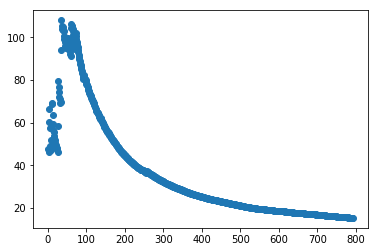

In [6]:
mses = moving_average(sses)
plt.scatter(range(len(mses)), mses)
plt.show()